# Image Captioning Task
This notebook focuses on the Image Captioning task, where a model predicts a caption describing a given image. The model follows an encoder-decoder architecture:

Encoder: A vision-based CNN architecture.
Decoder: A sequence-based model (RNN, LSTM, Transformer, etc.).

# Dataset:

Training and validation: Flickr8k dataset (Kaggle link).
Evaluation: The model's performance will be assessed using the BLEU score.

# Instructions:
Create the architecture and train it on the training set.
Optimize the model using the techniques learned so far.

In [1]:
import glob
import torch
import torchvision.transforms as transforms
from PIL import Image
import os
import pandas as pd  # for lookup in annotation file
import spacy  # for tokenizer
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence  # pad batch
from torch.utils.data import DataLoader, Dataset
import statistics
import torchvision.models as models
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim


In [2]:
# Download with: python -m spacy download en
nltk.download('punkt')
spacy_eng = spacy.load("en_core_web_sm")


[nltk_data] Downloading package punkt to /home/preeti/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
def save_checkpoint(state, filename="checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    step = checkpoint["step"]
    return step

In [4]:
# Define Vocabulary class
class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1
                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)
        return [self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokenized_text]


In [5]:
# Define FlickrDataset class
class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions.tolist())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return img, torch.tensor(numericalized_caption)

In [6]:
# Define MyCollate class
class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)
        return imgs, targets

In [7]:
# Define get_loader function
def get_loader(root_folder, annotation_file, transform, batch_size=32, num_workers=8, shuffle=True, pin_memory=True):
    dataset = FlickrDataset(root_folder, annotation_file, transform=transform)
    pad_idx = dataset.vocab.stoi["<PAD>"]

    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=MyCollate(pad_idx=pad_idx),
    )

    return loader, dataset

/home/preeti/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:136: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
/home/preeti/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:136: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers)

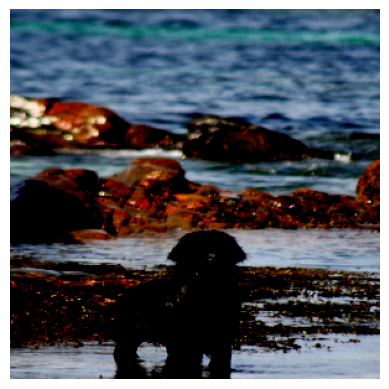

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Caption: <SOS> a black dog standing in a shallow area of water on a rocky beach . <EOS> <PAD> <PAD> <PAD>



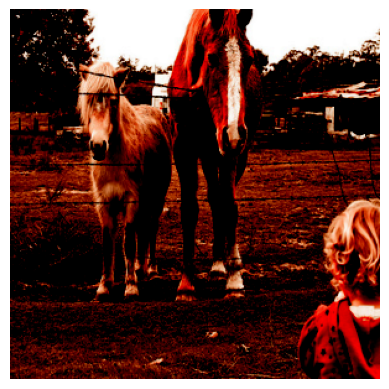

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Caption: <SOS> two horses are looking at a small child . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>



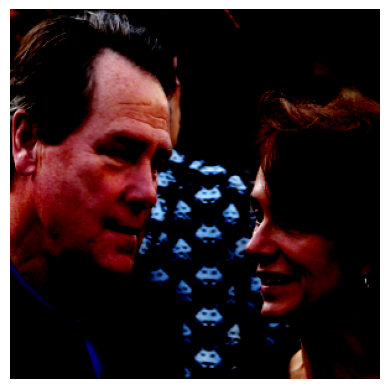

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Caption: <SOS> a man looks at a woman and she smiles . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>



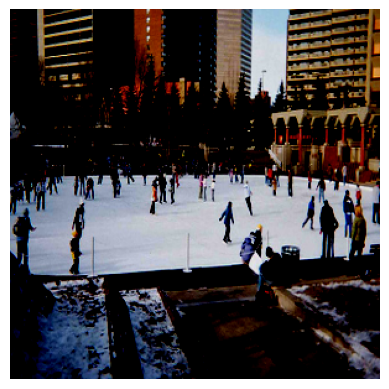

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Caption: <SOS> people using an outdoor ice skating rink . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>



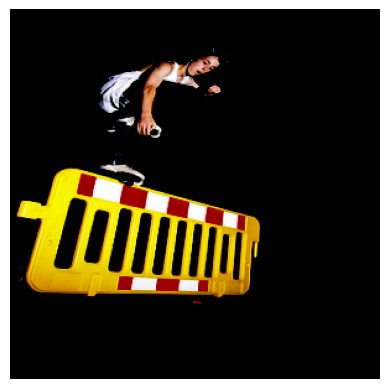

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Caption: <SOS> a person jumps onto a barrier . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>



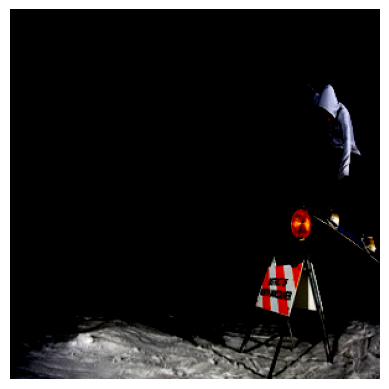

Caption: <SOS> a man is snowboarding over a caution sign . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


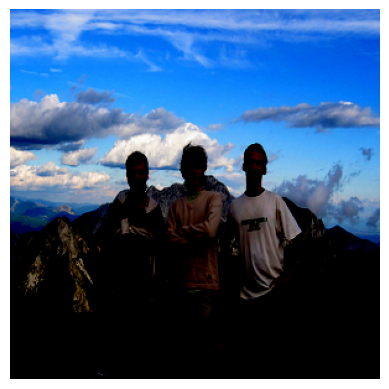

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Caption: <SOS> these three young men are standing on a mountaintop . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>



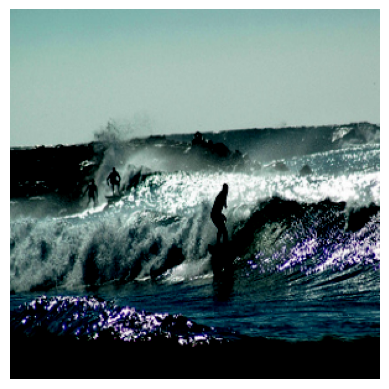

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Caption: <SOS> someone is riding a blue wave . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>



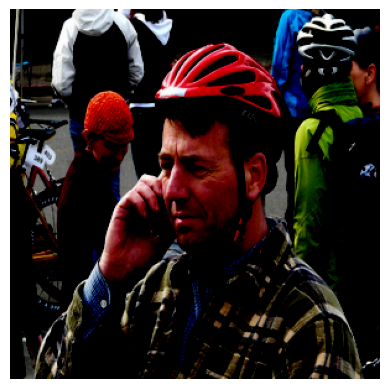

Caption: <SOS> a man with a bicycle helmet on is using a cellphone in the midst of a crowd . <EOS>



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


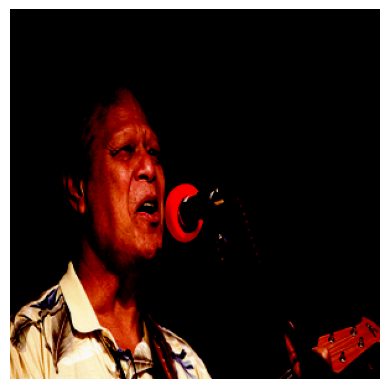

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Caption: <SOS> a man playing guitar sings into a microphone . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>



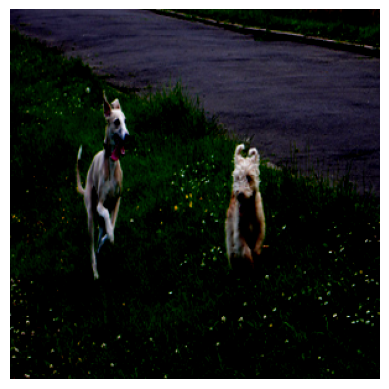

Caption: <SOS> two dogs running in grass <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


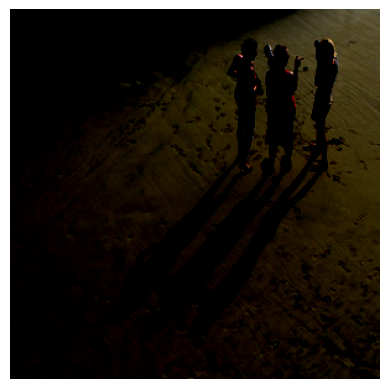

Caption: <SOS> a group of girls on a beach . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


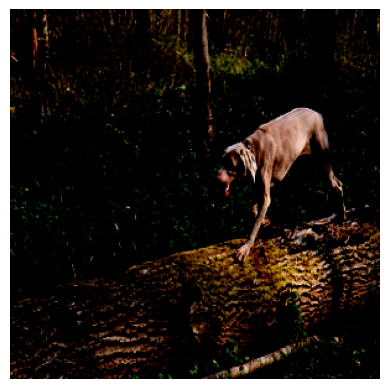

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Caption: <SOS> a grey dog walks on top of a fallen tree in the woods . <EOS> <PAD> <PAD> <PAD> <PAD>



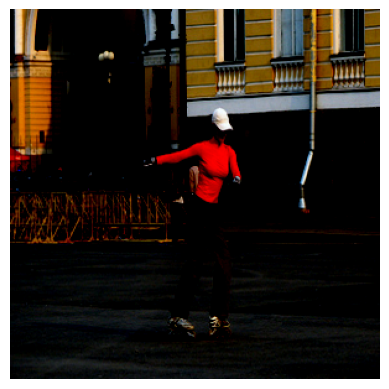

Caption: <SOS> a girl in a red shirt and brown pants is skating . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


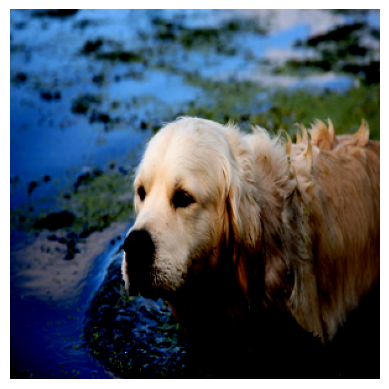

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Caption: <SOS> a light tan dog swimming through swampy water . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>



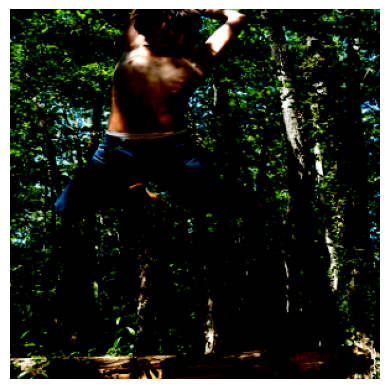

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Caption: <SOS> a guy leaps into the air in a wooded area . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>



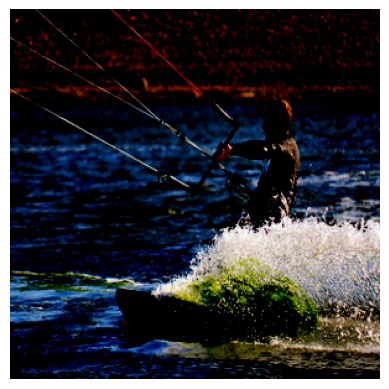

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Caption: <SOS> a man is pulled through the water on a large ski . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>



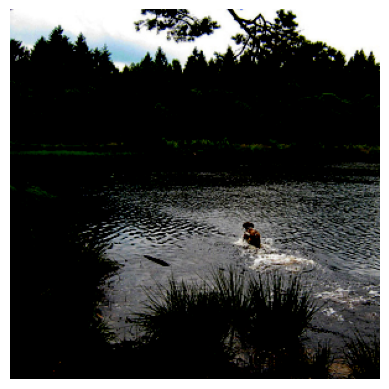

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Caption: <SOS> a dog is running through a lake towards some trees . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>



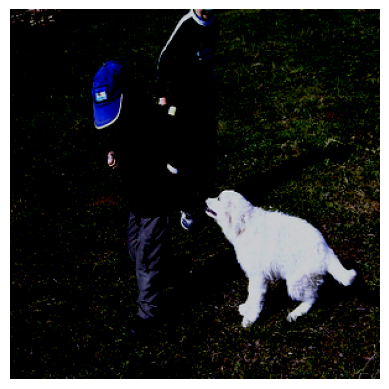

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Caption: <SOS> two kids playing with a dog . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>



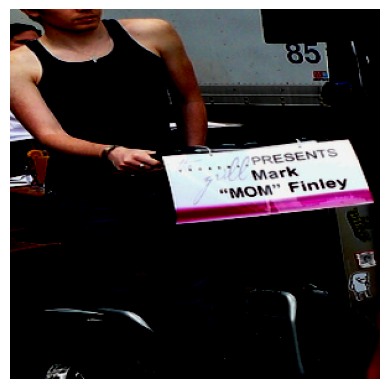

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Caption: <SOS> a person wearing blue jeans and a blue tank top stands and waits . <EOS> <PAD> <PAD> <PAD> <PAD>



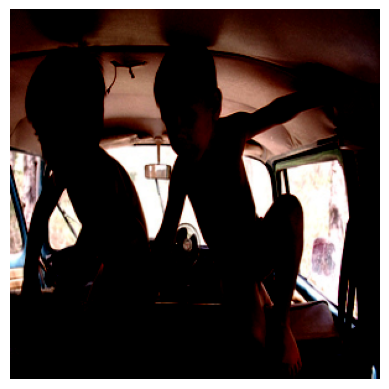

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Caption: <SOS> two small boys wearing only their underwear climbing a bench in a van <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>



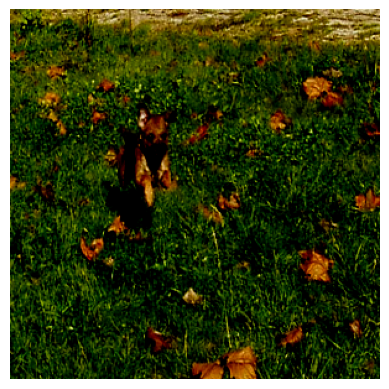

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Caption: <SOS> a little brown dog is running on the grass . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>



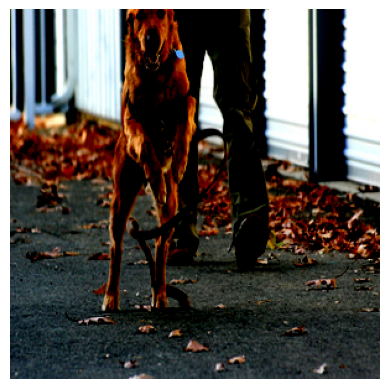

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Caption: <SOS> a man is walking behind a dog that is standing on its hind legs . <EOS> <PAD> <PAD> <PAD>



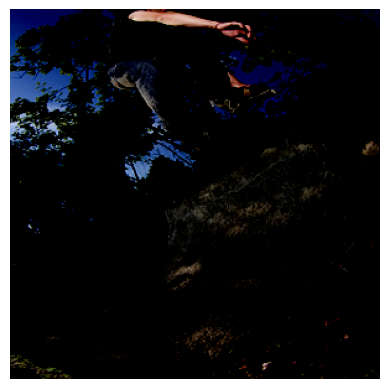

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Caption: <SOS> a man with rollerblades grinding a curb . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>



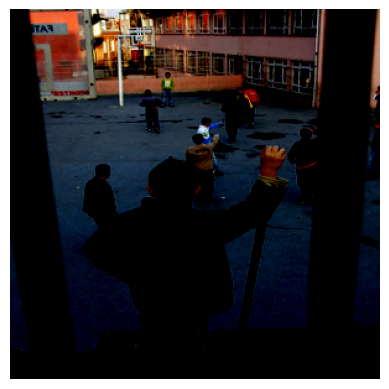

Caption: <SOS> a boy standing in the foreground looking out over other people in a court . <EOS> <PAD> <PAD> <PAD>



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


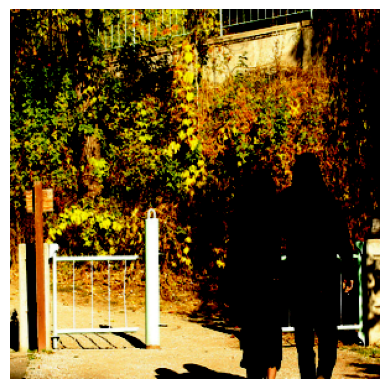

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Caption: <SOS> a man and a woman dressed in black walk towards a gate near a wooded area . <EOS> <PAD>



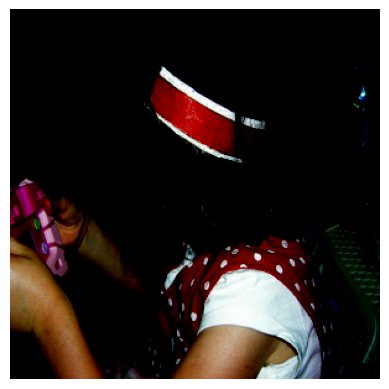

Caption: <SOS> a girl with a camera , looking at the screen . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


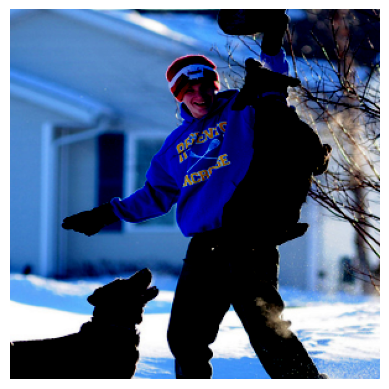

Caption: <SOS> two dogs play with a human and a disc in the snow . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


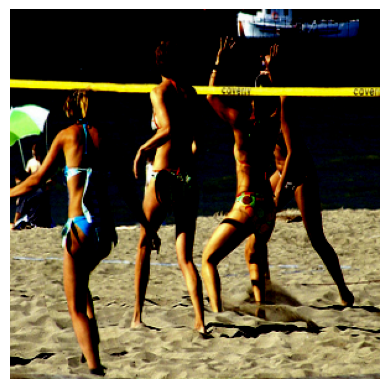

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Caption: <SOS> four ladies in swimsuits play sand volleyball on the beach . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>



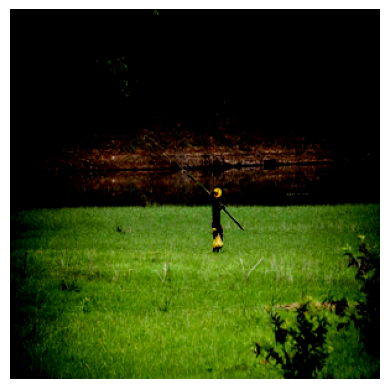

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Caption: <SOS> man holding stick in field of green grass . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>



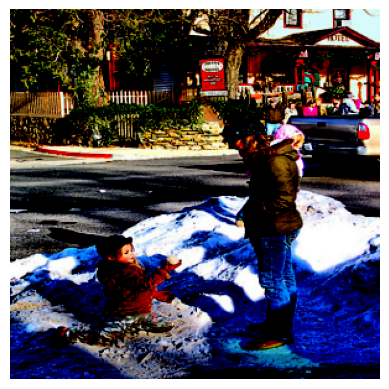

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Caption: <SOS> two children play in the snow by the side of the road . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>



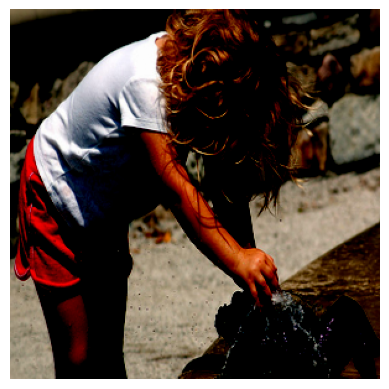

Caption: <SOS> a girl looks at a fountain that sprays water . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>



In [8]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

def numericalized_caption_to_text(numericalized_caption, vocab):
    # Filter out indices that are not in the vocabulary
    valid_indices = [idx.item() for idx in numericalized_caption if idx.item() < len(vocab.itos)]
    # Convert valid indices to text
    return " ".join([vocab.itos[idx] for idx in valid_indices])


# Updated function to display a few examples
def display_examples(loader, dataset, num_examples=5):
    example_count = 0  # Variable to track the number of displayed examples

    # Get a batch of data
    for i, (images, captions) in enumerate(loader):
        if i >= num_examples:
            break

        # Display images
        for j in range(images.size(0)):
            image = images[j].permute(1, 2, 0).numpy()
            plt.imshow(image)
            plt.axis("off")
            plt.show()

            # Convert numericalized captions to text
            caption_text = numericalized_caption_to_text(captions[:, j], dataset.vocab)
            print(f"Caption: {caption_text}\n")

        example_count += images.size(0)

        if example_count >= num_examples:
            break  # Break out of the outer loop once the desired number of examples is reached

# Set up the DataLoader
transform = transforms.Compose([
    transforms.Resize((356, 356)),
    transforms.RandomCrop((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

root_folder = "/home/preeti/Downloads/image_captioning/flickr8k"
annotation_file = "/home/preeti/Downloads/image_captioning/captions.txt"

loader, dataset = get_loader(
    root_folder=root_folder,
    annotation_file=annotation_file,
    transform=transform,
    batch_size=32,  # Adjust the batch size if needed
    num_workers=2,
    shuffle=True,
    pin_memory=True,
)

# Display examples
display_examples(loader, dataset, num_examples=5)

In [10]:
# Define EncoderCNN class
class EncoderCNN(nn.Module):
    def __init__(self, embed_size, train_CNN=False):
        super(EncoderCNN, self).__init__()
        self.train_CNN = train_CNN
        self.inception = models.inception_v3(pretrained=True, aux_logits=True)
        self.inception.fc = nn.Linear(self.inception.fc.in_features, embed_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, images):
        features = self.inception(images)
        return self.dropout(self.relu(features[0]))

# Define DecoderRNN class
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions))
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs

In [11]:
# Define CNNtoRNN class
class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size)
        self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoderCNN(images)
        outputs = self.decoderRNN(features, captions)
        return outputs

    def caption_image(self, image, vocabulary, max_length=50):
        result_caption = []

        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0)
            states = None

            for _ in range(max_length):
                hiddens, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                predicted = output.argmax(-1)
                result_caption.append(predicted.item())
                x = self.decoderRNN.embed(predicted).unsqueeze(0)

                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break

        return [vocabulary.itos[idx] for idx in result_caption]


In [12]:
# Define training function
def train():
    transform = transforms.Compose(
        [
            transforms.Resize((356, 356)),
            transforms.RandomCrop((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

    train_loader, dataset = get_loader(
        root_folder="/home/preeti/Downloads/image_captioning/flickr8k",
        annotation_file="/home/preeti/Downloads/image_captioning/captions.txt",
        transform=transform,
        num_workers=2,
    )

    torch.backends.cudnn.benchmark = True
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    load_model = False
    save_model = True
    train_CNN = True

    # Hyperparameters
    embed_size = 256
    hidden_size = 256
    vocab_size = len(dataset.vocab)
    num_layers = 1
    learning_rate = 0.001
    num_epochs = 5

    # for tensorboard
    writer = SummaryWriter("runs/flickr")
    step = 0

    # initialize model, loss etc
    model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Only finetune the CNN
    for name, param in model.encoderCNN.inception.named_parameters():
        if "fc.weight" in name or "fc.bias" in name:
            param.requires_grad = True
        else:
            param.requires_grad = train_CNN

    if load_model:
        step = load_checkpoint(torch.load(
            "/home/preeti/Downloads/image_captioning/my_checkpoint.pth.tar"), model, optimizer)

    model.train()

    for epoch in range(num_epochs):
        if save_model:
            checkpoint = {
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "step": step,
            }
            save_checkpoint(checkpoint)

        for idx, (imgs, captions) in enumerate(train_loader):
            imgs = imgs.to(device)
            captions = captions.to(device)

            outputs = model(imgs, captions[:-1])
            loss = criterion(outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1))

            writer.add_scalar("Training loss", loss.item(), global_step=step)
            step += 1

            optimizer.zero_grad()
            loss.backward(loss)
            optimizer.step()

            if idx % 1000 == 0:  
                print(
                    f"Epoch [{epoch}/{num_epochs}], Step [{idx}/{len(train_loader)}], Loss: {loss.item():.4f}"
                )


# Training the model
train()

=> Saving checkpoint


/home/preeti/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:136: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
/home/preeti/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:136: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))


Epoch [0/5], Step [0/1265], Loss: 8.0051


In [ ]:

import csv

# Read the captions from the text file
with open('/home/preeti/Downloads/output_captions.txt', 'r') as file:
    captions = file.readlines()

# Process and format the data
data = []
for caption in captions:
    parts = caption.split(',')
    image_name = parts[0]
    predicted_caption = parts[1].replace(
        '<SOS>', '').replace('<EOS>', '').strip()
    # Remove space before full stop
    predicted_caption = predicted_caption.rstrip('.').strip()
    data.append([image_name, predicted_caption])

# Write the data to a CSV file
with open('captions.csv', 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    # Write the header
    csv_writer.writerow(['image_name', 'predicted_caption'])
    # Write the data
    csv_writer.writerows(data)